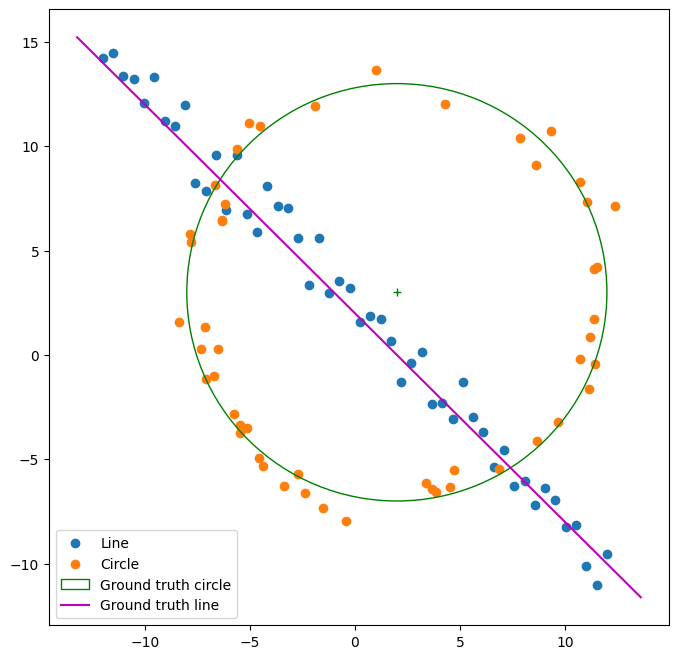

In [1]:
from scipy.optimize import minimize
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

t = np.random.uniform(0, 2*np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)

X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s * np.random.randn(half_n)

X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()

In [6]:
import math
from scipy.optimize import minimize

N = x_.shape[0]
X_circ = x_

# Threshold value to determine inliers (radial error)
t_circle = 1.0
def circle_equation_from_points(x1, y1, x2, y2, x3, y3):
    d = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / d
    uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / d
    r = np.sqrt(ux**2 + uy**2 + ((x1**2 + y1**2) * (x2 * y3 - x3 * y2) + (x2**2 + y2**2) * (x3 * y1 - x1 * y3) + (x3**2 + y3**2) * (x1 * y2 - x2 * y1)) / d)
    return ux, uy, r

# RANSAC to fit a circle
def circle_tls(x, indices):
    ux, uy, r = x[0], x[1], x[2]
    radial_errors = np.abs(np.sqrt((X_circ[indices, 0] - ux)**2 + (X_circ[indices, 1] - uy)**2) - r)
    return np.sum(np.square(radial_errors))


def consensus_circle(X, x, t):
    ux, uy, r = x[0], x[1], x[2]
    radial_error = np.abs(np.sqrt((X[:, 0] - ux)**2 + (X[:, 1] - uy)**2) - r)
    return radial_error < t

# Constraint for circle parameters
def h(x):
    return x[2] - 10

circle_cons = ({'type': 'ineq', 'fun': h})


# Number of close data points required to assert that a model fits well to data (circle)
d_circle = 0.4 * N

inliers_circle = []
best_model_circle = []
best_inliers_circle = []
best_error_circle = np.inf
best_sample_circle = []

iteration = 0
maX_circiterations_circle = 50

s_circle = 3

while iteration < maX_circiterations_circle:
    indices_circle = np.random.randint(0,N, s_circle)
    x0_circle = circle_equation_from_points(X_circ[indices_circle[0], 0], X_circ[indices_circle[0], 1], X_circ[indices_circle[1], 0], X_circ[indices_circle[1], 1], X_circ[indices_circle[2], 0], X_circ[indices_circle[2], 1])
    res_circle = minimize(fun=circle_tls, args=(inliers_circle), x0=x0_circle, tol=1e-6, constraints=circle_cons)
    inliers_circle = consensus_circle(X_circ, res_circle.x, t_circle)
    print(f'Circle Iteration {iteration}, No. inliers = {inliers_circle.sum()}')
    if inliers_circle.sum() > d_circle:
        x0_circle = res_circle.x
        res_circle = minimize(fun=circle_tls, args=(inliers_circle), x0=x0_circle, tol=1e-6, constraints=circle_cons)
        if res_circle.fun < best_error_circle:
            print('A better model found ... ', res_circle.x, res_circle.fun)
            best_model_circle = res_circle.x
            best_error_circle = res_circle.fun
            best_inliers_circle = inliers_circle
            best_sample_circle = X_circ[indices_circle,:]
    iteration += 1

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed